In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import holidays

In [2]:
#Ścieżka dostępu do pliku
path = r"Diagnostyka_KPEC_calosciowo.xlsm"

index_col = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,39,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,36,]
names = ['Data',' Rok',' Miesiac',' Dzień',' Okres grzewczy',' Tz Miasto',' Tp Miasto',' V Miasto',' V obj. Miasto',' P Miasto obl.',' Tz Fordon',' Tp Fordon',' V Fordon',' V obj. Fordon',' P Fordon obl.',' P EC2 obl.',' P EC2',' Tz EC1',' Tp EC1',' V EC1',' V obj. EC1',' P EC1 obl.',' P EC1',' Tz BialeBlota',' Tp BialeBlota',' V BialeBlota',' V obj. BialeBlota',' P BialeBlota obl.',' P BialeBlota',' Tz ZTPOK',' Tp ZTPOK',' V ZTPOK',' V obj. ZTPOK',' P ZTPOK obl.',' P ZTPOK',' V SUMA obl. [m3/h]',' Temp powietrza  zewn - licznik',' Temp_wody_zasilanie',' Temp_wody_powrot ',' V całkowity ',' ΔT rzeczywista',' Temp_zewnetrzna Te12h [°C]',' Tz_norm [°C]',' Tp_norm [°C]',' odchylenie Tz od normatywu',' odchylenie Tp od normatywu ',' ΔT normatywna ',' odchylenie ΔT od normatywu ',' Tzopt',' Tpopt ',' odchylenie Tz od optymalnej ',' odchylenie Tp od optymalnej ',' ΔT optymalna',' odchylenie ΔT od optymalnej ',' Współczynnik obciążenia',' Nϕ',' Vrz ',' Vnorm',' Vopt ',' Vnormϕ ',' P SUMA obl.']
#Zaczytanie danych do DF
sheet_name = 'Dane 2019-2021'
dataset = pd.read_excel(path,
                        sheet_name=sheet_name,
                       usecols=index_col#,
                        #names = names
)


dataset['DataCzas'] = pd.to_datetime(dataset['DataCzas'])
dataset.set_index('DataCzas', drop = True, inplace = True)


In [3]:
print(dataset.columns)


Index(['Rok', 'Miesiac', 'Dzień', 'Okres\ngrzewczy', 'Tzas Miasto\n[oC]',
       'Tpow Miasto\n[oC]', 'Przepływ Miasto\n[t/h]',
       'Przepływ obj. Miasto\n[m3/h]', 'Moc Miasto obl.\n[MW]',
       'Tzas Fordon\n[oC]', 'Tpow Fordon\n[oC]', 'Przepływ Fordon\n[t/h]',
       'Przepływ obj. Fordon\n[m3/h]', 'Moc Fordon obl.\n[MW]',
       'Moc EC2 obl.\n[MW]', 'Moc EC2\n[MW]', 'Tzas EC1\n[oC]',
       'Tpow EC1\n[oC]', 'Przepływ EC1\n[t/h]', 'Przepływ obj. EC1\n[m3/h]',
       'Moc EC1 obl.\n[MW]', 'Moc EC1\n[MW]', 'Tzas BialeBlota\n[oC]',
       'Tpow BialeBlota\n[oC]', 'Przepływ BialeBlota\n[t/h]',
       'Przepływ obj. BialeBlota\n[m3/h]', 'Moc BialeBlota obl.\n[MW]',
       'Moc BialeBlota\n[MW]', 'Tzas ZTPOK\n[oC]', 'Tpow ZTPOK\n[oC]',
       'Przepływ ZTPOK\n[t/h]', 'Przepływ obj. ZTPOK\n[m3/h]',
       'Moc ZTPOK obl.\n[MW]', 'Moc ZTPOK\n[MW]', 'Przepływ SUMA obl. [m3/h]',
       'Moc SUMA obl.\n[MW]', 'Temp powietrza\n zewn - licznik\n[°C]',
       'Temp_wody_zasilanie\n Tz [°C]',

In [4]:
df = dataset.copy()
df1 = df[['Rok', 
          'Miesiac', 
          'Dzień', 
          'Okres\ngrzewczy',
          'Temp powietrza\n zewn - licznik\n[°C]',
          'Moc Miasto obl.\n[MW]',
          'Moc Fordon obl.\n[MW]',
          'Moc EC1 obl.\n[MW]',
          'Moc ZTPOK obl.\n[MW]',
          'Moc BialeBlota\n[MW]',
          'Moc SUMA obl.\n[MW]']].copy()

df1['Godzina'] = df1.index.hour
df1['DzieńTygodnia'] = df1.index.day_of_week
df1['Kwartał'] = df1.index.quarter


pl_holidays = holidays.Poland(years=[df.index.year.min(), df.index.year.max()])
range_of_dates = pd.date_range(str(df.index.min())[:10], str(df.index.max())[:10])
df1['Swieto'] = [index in pl_holidays for index in df.index]



df1.rename({'Moc SUMA obl.\n[MW]': 'Moc', 
            'Okres\ngrzewczy': 'OkresGrzewczy',
           'Temp powietrza\n zewn - licznik\n[°C]': "TempZewn",
           'Moc Miasto obl.\n[MW]': 'MocMiasto',
           'Moc Fordon obl.\n[MW]': 'MocFordon',
           'Moc EC1 obl.\n[MW]' :'MocECI',
           'Moc ZTPOK obl.\n[MW]' :'MocZTPOK',
           'Moc BialeBlota\n[MW]' : 'MocBialeBlota'}, axis = 1, inplace = True)

kolumny = ['Rok', 
           'Kwartał', 
           'Miesiac', 
           'Dzień', 
           'DzieńTygodnia',
           'Godzina',
           'OkresGrzewczy',
           'Swieto',
           'TempZewn',
           'MocMiasto',
           'MocFordon',
           'MocECI',
           'MocZTPOK',
           'MocBialeBlota',
           'Moc']

df1 = df1[kolumny]

df1['OkresGrzewczy'].fillna("nOg", inplace = True)
df1['Moc'] = df1['Moc'].interpolate()
df1['MocMiasto'] = df1['MocMiasto'].interpolate()
df1['MocFordon'] = df1['MocFordon'].interpolate()
df1['MocECI'] = df1['MocECI'].interpolate()
df1['MocZTPOK'] = df1['MocZTPOK'].interpolate()
#df1['MocBialeBlota'] = df1['MocBialeBlota'].interpolate()
df1['MocBialeBlota'].fillna(0, inplace = True)
df1['TempZewn'] = df1['TempZewn'].interpolate()



In [5]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [6,7])], remainder='passthrough')
df2 = ct.fit_transform(df1)
df2 = pd.DataFrame(df2, index = df1.index)
df2.columns = ['nOg',
               'og',
               'nSwieto',
               'Swieto',
               'Rok', 
               'Kwartał', 
               'Miesiac', 
               'Dzień', 
               'DzieńTygodnia',
               'Godzina',
               'TempZewn',
               'MocMiasto',
               'MocFordon',
               'MocECI', 
               'MocZTPOK',
               'MocBialeBlota',
               'Moc']
df1 = df2.copy()

In [6]:
kolumny = df1.columns

# X = df1[kolumny[:-1]]
# y = df1[kolumny[-1]]

# data_dmatrix = xgb.DMatrix(data = X, label = y) 


# from sklearn.model_selection import train_test_split
# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# train = df1[df1.index < '2021-02-15']
# test = df1[df1.index >= '2021-02-15']
train = df1[df1.index < '2020-09-01']
test = df1[df1.index >= '2020-09-01']



FEATURES = kolumny[:-1]
TARGET = kolumny[-1]

X_train = train[FEATURES]
X_test = test[FEATURES]

y_train = train[TARGET]
y_test = test[TARGET]

In [7]:
n_estimators = 20000
listEstimators = [100,250,500,750,1000,1500,2000, 2500, 5000,10000,20000]
results = []


for n_estimators in listEstimators:

    reg = xgb.XGBRegressor(base_score = 0.5,
                               booster = 'gbtree',
                               n_estimators = n_estimators,
                               early_stopping_rounds = 50,
                               objective = 'reg:linear',
                               max_depth = 3,
                               learning_rate = 0.01
    #     n_estimators = 20000,
    #        early_stopping_rounds = 50,
    #         learning_rate = 0.001
                          )
    reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train),(X_test, y_test)],
           verbose = False)

#     (pd.DataFrame(data = reg.feature_importances_,
#                 index = reg.feature_names_in_,
#                 columns = ['importance'])) \
#     .sort_values(by = 'importance') \
#     .plot(kind = 'barh')
#     plt.xlabel('Importance')
#     plt.ylabel('Feature')
#     plt.show()

    test['Predykcja'] = reg.predict(X_test)
#     fig, ax = plt.subplots(figsize = (15,6))
#     df1['Moc'].plot(ax = ax)
#     test['Predykcja'].plot(ax = ax)

#     plt.legend(loc = 'best')
#     plt.show()

    R2 = round(r2_score(test['Moc'], test['Predykcja']),5)
    MAPE = round(mape(test['Moc'], test['Predykcja']),4)

    print(f'Metrics for prediction: \n - R2 = {R2} \n - MAPE = {MAPE*100}%')
    print()
    print("****************")

    results.append([R2,MAPE,n_estimators])
    
print(results)

[20:50:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Metrics for prediction: 
 - R2 = 0.41249 
 - MAPE = 36.27%

****************
[20:50:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Metrics for prediction: 
 - R2 = 0.94652 
 - MAPE = 10.09%

****************
[20:50:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Metrics for prediction: 
 - R2 = 0.98813 
 - MAPE = 4.84%

****************
[20:50:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/ob

In [8]:
resultsDf = pd.DataFrame(results, columns = ['R2','MAPE','n_estimators'])
resultsDf

,R2,MAPE,n_estimators
0,0.41249,0.3627,100
1,0.94652,0.1009,250
2,0.98813,0.0484,500
3,0.99181,0.0418,750
4,0.99277,0.0381,1000
5,0.99373,0.0349,1500
6,0.99432,0.0329,2000
7,0.99478,0.0312,2500
8,0.99578,0.0258,5000
9,0.99618,0.0230,10000


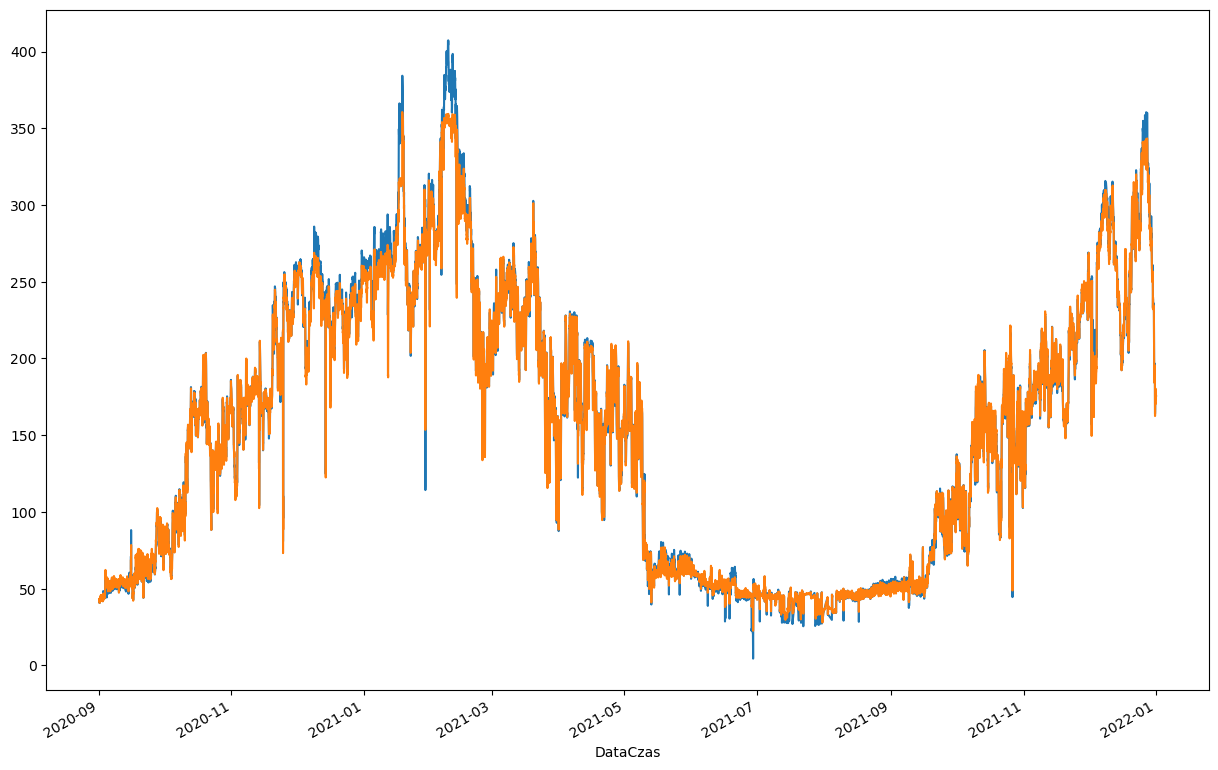

In [9]:
fig, ax = plt.subplots(figsize = (15,10))
test['Moc'].plot(ax = ax)
test['Predykcja'].plot(ax = ax)
plt.show()

In [10]:
test['Różnica'] = abs(test['Moc'] - test['Predykcja'])
test.sort_values(by = 'Różnica', ascending = False).tail(10)

,nOg,og,nSwieto,Swieto,Rok,Kwartał,Miesiac,Dzień,DzieńTygodnia,Godzina,TempZewn,MocMiasto,MocFordon,MocECI,MocZTPOK,MocBialeBlota,Moc,Predykcja,Różnica
DataCzas,,,,,,,,,,,,,,,,,,,
2021-07-24 09:59:59.995,1.0,0.0,1.0,0.0,2021.0,3.0,7.0,24.0,5.0,9.0,22.865753,19.093332,11.327670,0.000000,15.978394,0.000000,46.399396,46.401917,0.002520
2021-12-31 06:59:59.994,0.0,1.0,1.0,0.0,2021.0,4.0,12.0,31.0,4.0,6.0,9.800000,105.128396,37.787820,16.285858,24.920809,0.303524,184.122883,184.120621,0.002262
2021-04-08 02:59:59.996,0.0,1.0,1.0,0.0,2021.0,2.0,4.0,8.0,3.0,2.0,2.400000,141.619356,47.887075,0.000000,27.535585,0.000000,217.042016,217.040085,0.001931
2021-05-03 22:59:59.996,0.0,1.0,0.0,1.0,2021.0,2.0,5.0,3.0,0.0,22.0,4.600000,118.726059,41.155810,0.000000,28.126019,0.000000,188.007888,188.006165,0.001723
2021-07-15 17:59:59.995,1.0,0.0,1.0,0.0,2021.0,3.0,7.0,15.0,3.0,17.0,28.400000,17.684723,10.727468,0.000000,15.676883,0.000000,44.089075,44.090786,0.001711
2021-06-13 20:59:59.995,1.0,0.0,1.0,0.0,2021.0,2.0,6.0,13.0,6.0,20.0,15.900000,25.517470,13.143735,0.000000,16.951967,0.046656,55.613172,55.611832,0.001340
2021-05-06 02:59:59.996,0.0,1.0,1.0,0.0,2021.0,2.0,5.0,6.0,3.0,2.0,6.800000,103.165227,36.261353,0.000000,23.973797,0.000000,163.400377,163.401443,0.001067
2021-09-15 04:59:59.995,1.0,0.0,1.0,0.0,2021.0,3.0,9.0,15.0,2.0,4.0,8.800000,38.622826,11.989184,0.000000,0.000000,0.000000,50.612009,50.612572,0.000562
2021-11-01 08:59:59.995,0.0,1.0,0.0,1.0,2021.0,4.0,11.0,1.0,0.0,8.0,8.000000,89.319986,33.696042,0.000000,27.395923,0.000000,150.411951,150.412277,0.000326


In [11]:
test.sort_values(by = 'Różnica', ascending = False).head(10)

,nOg,og,nSwieto,Swieto,Rok,Kwartał,Miesiac,Dzień,DzieńTygodnia,Godzina,TempZewn,MocMiasto,MocFordon,MocECI,MocZTPOK,MocBialeBlota,Moc,Predykcja,Różnica
DataCzas,,,,,,,,,,,,,,,,,,,
2021-01-12 03:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,12.0,1.0,3.0,-0.185714,179.090425,24.796722,0.000000,27.457303,0.000000,247.890571,187.655106,60.235466
2021-01-12 02:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,12.0,1.0,2.0,-0.257143,180.572597,16.531148,0.000000,27.576051,0.000000,241.384496,189.547699,51.836797
2021-01-17 08:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,17.0,6.0,8.0,-15.500000,232.638242,86.241428,0.000000,28.256632,18.936022,366.207511,315.230011,50.977500
2021-01-17 09:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,17.0,6.0,9.0,-15.200000,233.396980,85.968739,0.000000,26.573125,19.255810,365.624070,315.581085,50.042984
2021-01-17 20:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,17.0,6.0,20.0,-16.000000,232.869947,85.252390,0.000000,27.684636,19.457980,365.731843,317.372101,48.359742
2021-01-17 10:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,17.0,6.0,10.0,-13.700000,231.760306,86.631875,0.000000,27.365485,18.500010,364.853342,316.580200,48.273142
2021-02-08 20:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,2.0,8.0,0.0,20.0,-9.900000,254.241321,82.765858,37.676577,15.003291,17.255119,407.224873,359.361145,47.863728
2021-02-08 17:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,2.0,8.0,0.0,17.0,-10.200000,255.199749,82.458302,38.190908,13.905345,17.100634,407.016984,359.269806,47.747178
2021-01-17 23:59:59.996,0.0,1.0,1.0,0.0,2021.0,1.0,1.0,18.0,6.0,23.0,-17.100000,232.165750,84.175947,0.000000,25.470038,19.831100,362.237189,315.606598,46.630591


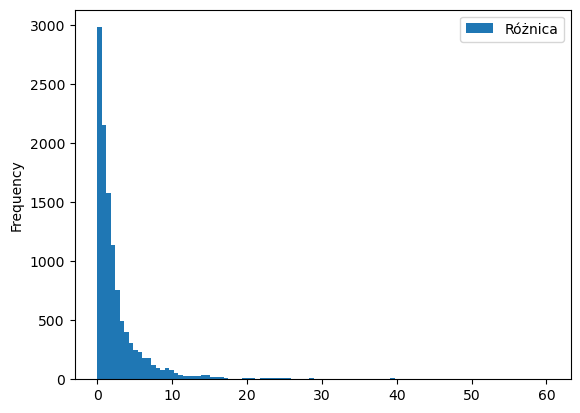

In [12]:
test.plot(kind = 'hist' ,y = 'Różnica', bins = 100)
plt.show()

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5,
                     test_size = 24*6*31,
                     gap = 24)

df1.sort_index()

fold = 0
preds = []
scores = []
data = []

dfTemp = pd.DataFrame()

for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    
    kolumny = df1.columns

    FEATURES = kolumny[:-1]
    TARGET = kolumny[-1]

    X_train = train[FEATURES]
    X_test = test[FEATURES]

    y_train = train[TARGET]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor( base_score = 0.5,
                           booster = 'gbtree',
                           n_estimators = 500,
                           early_stopping_rounds = 50,
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate = 0.01
                          )
    reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train),(X_test, y_test)],
       verbose = False)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = [r2_score(y_test, y_pred), mape(y_test, y_pred)]
    scores.append(score)
    
    data.append([y_train, y_test, y_pred])

[20:53:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regress

R2 = 0.97934, MAPE = 12.3003%


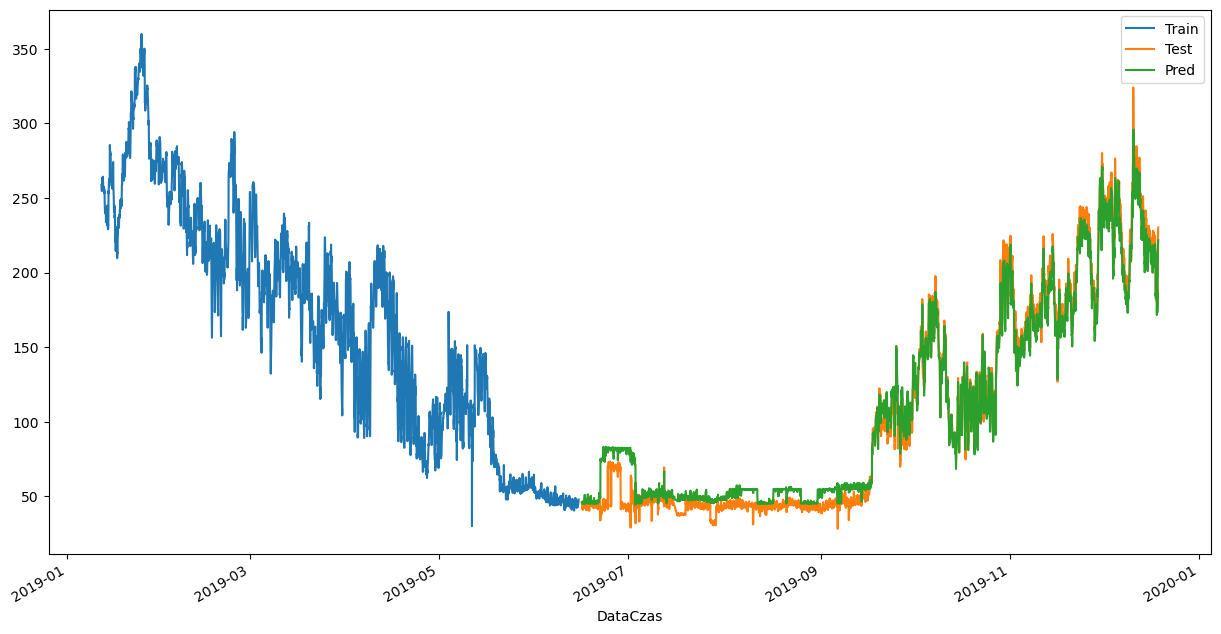

R2 = 0.9955, MAPE = 2.5111%


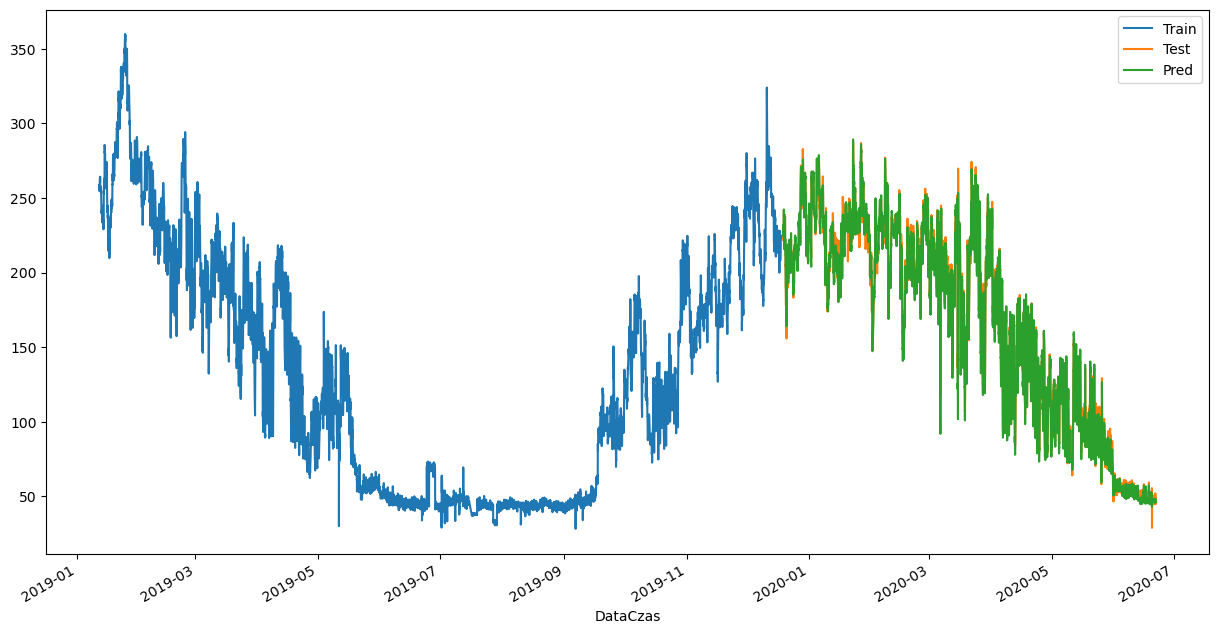

R2 = 0.99356, MAPE = 4.3957%


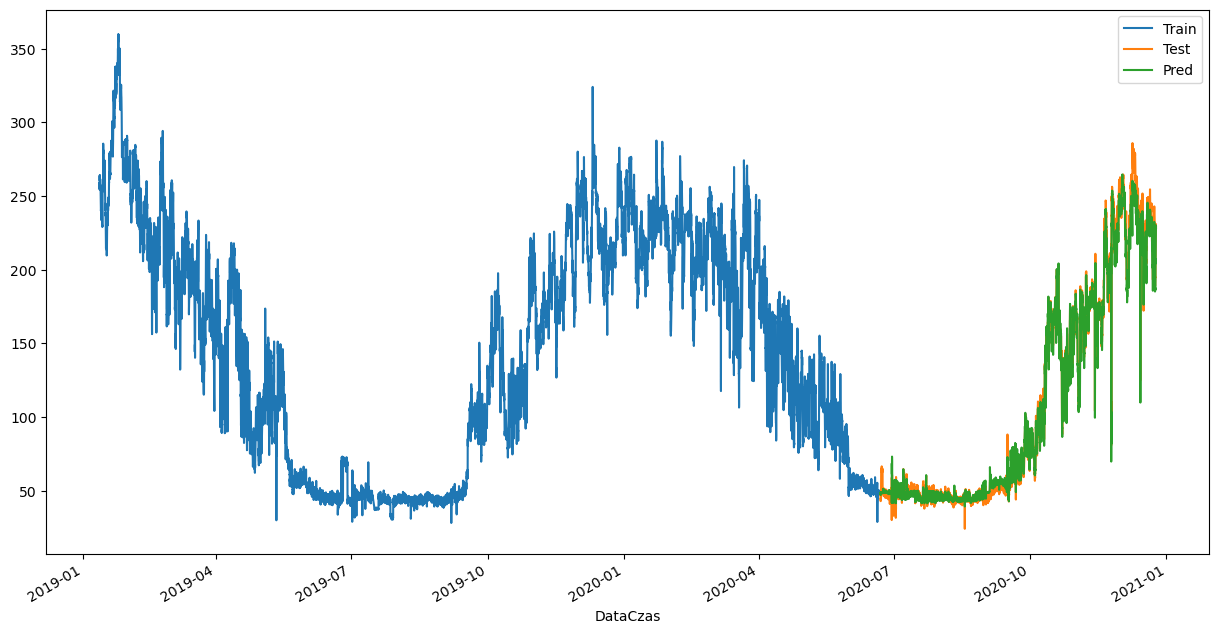

R2 = 0.98401, MAPE = 4.2312%


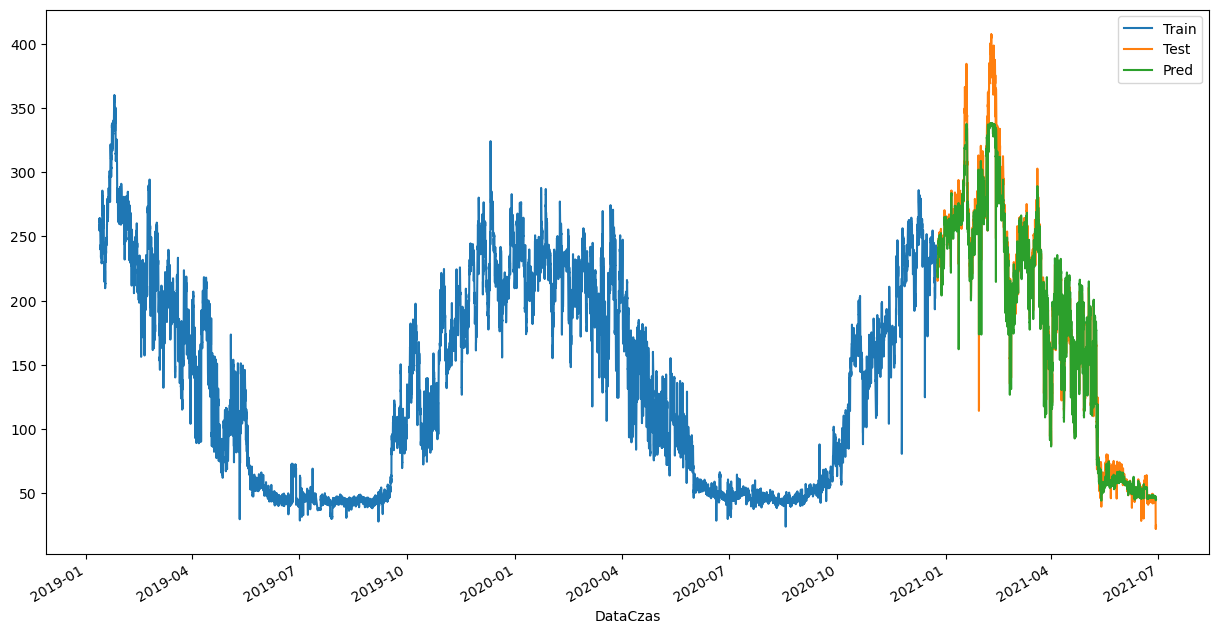

R2 = 0.99582, MAPE = 5.3223%


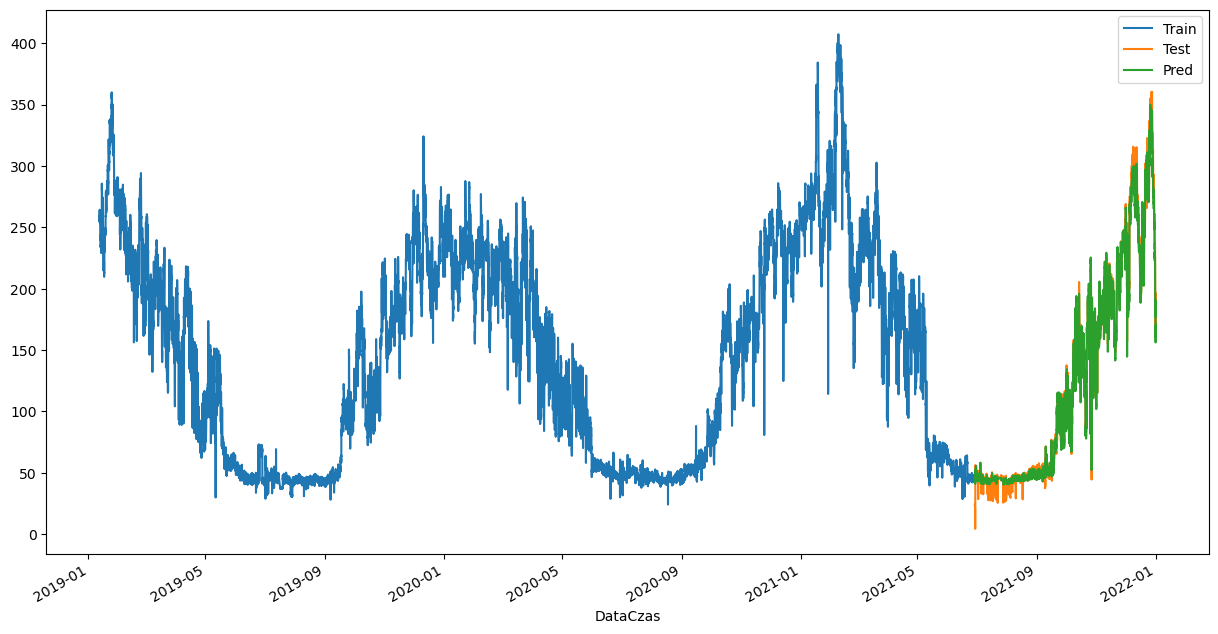

R2 = 0.97934, MAPE = 12.3003%
R2 = 0.9955, MAPE = 2.5111%
R2 = 0.99356, MAPE = 4.3957%
R2 = 0.98401, MAPE = 4.2312%
R2 = 0.99582, MAPE = 5.3223%


In [14]:
for i in range(5):
    print(f"R2 = {round(scores[i][0],5)}, MAPE = {round(scores[i][1]*100,4)}%")
    fig, ax = plt.subplots(figsize = (15,8))
    data[i][0].plot(ax = ax, label = 'Train')
    data[i][1].plot(ax = ax, label = 'Test')
    pd.DataFrame(data[i][2], index = data[i][1].index, columns = ['Pred']).plot(ax = ax, label = 'Pred')
    plt.legend(loc = 0)
    plt.show()
    
for score in scores:
    print(f"R2 = {round(score[0],5)}, MAPE = {round(score[1]*100,4)}%")

In [15]:
resultsDf

,R2,MAPE,n_estimators
0,0.41249,0.3627,100
1,0.94652,0.1009,250
2,0.98813,0.0484,500
3,0.99181,0.0418,750
4,0.99277,0.0381,1000
5,0.99373,0.0349,1500
6,0.99432,0.0329,2000
7,0.99478,0.0312,2500
8,0.99578,0.0258,5000
9,0.99618,0.0230,10000
